In [1]:
%matplotlib inline

In [2]:
from __future__ import unicode_literals, print_function, division
from io import open
import unicodedata
import string
import re
import random

import numpy as np
import torch
import torch.nn as nn
from torch import optim
import torch.nn.functional as F

from torchnlp.datasets import imdb_dataset
from torchnlp.datasets import penn_treebank_dataset

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

Loading data files
==================

The data for this project is a set of many thousands of English to
French translation pairs.

`This question on Open Data Stack
Exchange <https://opendata.stackexchange.com/questions/3888/dataset-of-sentences-translated-into-many-languages>`__
pointed me to the open translation site https://tatoeba.org/ which has
downloads available at https://tatoeba.org/eng/downloads - and better
yet, someone did the extra work of splitting language pairs into
individual text files here: https://www.manythings.org/anki/

The English to French pairs are too big to include in the repo, so
download to ``data/eng-fra.txt`` before continuing. The file is a tab
separated list of translation pairs:

::

    I am cold.    J'ai froid.

.. Note::
   Download the data from
   `here <https://download.pytorch.org/tutorial/data.zip>`_
   and extract it to the current directory.



Similar to the character encoding used in the character-level RNN
tutorials, we will be representing each word in a language as a one-hot
vector, or giant vector of zeros except for a single one (at the index
of the word). Compared to the dozens of characters that might exist in a
language, there are many many more words, so the encoding vector is much
larger. We will however cheat a bit and trim the data to only use a few
thousand words per language.

.. figure:: /_static/img/seq-seq-images/word-encoding.png
   :alt:





We'll need a unique index per word to use as the inputs and targets of
the networks later. To keep track of all this we will use a helper class
called ``Lang`` which has word → index (``word2index``) and index → word
(``index2word``) dictionaries, as well as a count of each word
``word2count`` to use to later replace rare words.




In [3]:
SOS_token = 0
EOS_token = 1
MASKED_token = 2


class Lang:
    def __init__(self, name):
        self.name = name
        self.word2index = {"SOSTOKEN": 0, "EOSTOKEN": 1, "MASKEDTOKEN": 2}
        self.index2word = {0: "SOSTOKEN", 1: "EOSTOKEN", 2: "MASKEDTOKEN"}
        self.word2count = {"SOSTOKEN": 0, "EOSTOKEN": 0, "MASKEDTOKEN": 0}
        
        self.n_words = 3  # Count SOS and EOS and Masked token

    def addSentence(self, sentence):
        for word in sentence.split(' '):
            self.addWord(word)

    def addWord(self, word):
        if word not in self.word2index:
            self.word2index[word] = self.n_words
            self.word2count[word] = 1
            self.index2word[self.n_words] = word
            self.n_words += 1
        else:
            self.word2count[word] += 1

The files are all in Unicode, to simplify we will turn Unicode
characters to ASCII, make everything lowercase, and trim most
punctuation.




In [4]:
def unicodeToAscii(s):
    """
    Turn a Unicode string to plain ASCII, thanks to
    https://stackoverflow.com/a/518232/2809427
    """
    return ''.join(
        c for c in unicodedata.normalize('NFD', s)
        if unicodedata.category(c) != 'Mn'
    )

def normalizeString(s):  # Lowercase, trim, and remove non-letter characters
    s = unicodeToAscii(s.lower().strip())
    #s = re.sub(r"([.!?])", r" \1", s)
    #s = re.sub(r"[^a-zA-Z.!?]+", r" ", s)
    s = re.sub(r"[^a-zA-Z]+", r" ", s)
    s = " ".join(s.split()[:40])
    return s

To read the data file we will split the file into lines, and then split
lines into pairs. The files are all English → Other Language, so if we
want to translate from Other Language → English I added the ``reverse``
flag to reverse the pairs.




In [5]:
def readLang(dataset_title):
    """
    Args:
        dataset_title: either 'imdb' or 'ptb'
    """
    print("Reading lines...")
    if dataset_title == 'imdb':
        train = imdb_dataset(train=True, directory='../data/')
        # Read the dataset and split into lines
        lines = [train[ind]['text'].strip() for ind, doc in enumerate(train)]
        # Normalize lines
        lines = [' '.join(["SOSTOKEN", normalizeString(s), "EOSTOKEN"]) for s in lines]
        lang = Lang(dataset_title)
    elif dataset_title == 'ptb':
        raise NotImplementedError
    return lang, lines

Since there are a *lot* of example sentences and we want to train
something quickly, we'll trim the data set to only relatively short and
simple sentences. Here the maximum length is 10 words (that includes
ending punctuation) and we're filtering to sentences that translate to
the form "I am" or "He is" etc. (accounting for apostrophes replaced
earlier).




In [6]:
"""MAX_LENGTH = 10

eng_prefixes = (
    "i am ", "i m ",
    "he is", "he s ",
    "she is", "she s ",
    "you are", "you re ",
    "we are", "we re ",
    "they are", "they re "
)
def filterPair(p):
    return len(p[0].split(' ')) < MAX_LENGTH and \
        len(p[1].split(' ')) < MAX_LENGTH and \
        p[1].startswith(eng_prefixes)
        
def filterPairs(pairs):
    return [pair for pair in pairs if filterPair(pair)]""";

The full process for preparing the data is:

-  Read text file and split into lines, split lines into pairs
-  Normalize text, filter by length and content
-  Make word lists from sentences in pairs




In [7]:
def prepareData(dataset_title):
    lang, lines = readLang(dataset_title)
    print("Read %s sentence pairs" % len(lines))
    print("Counting words...")
    for l in lines:
        lang.addSentence(l)
    print("Counted words:")
    print(lang.name, lang.n_words)
    return lang, lines

Reading lines...
Read 25000 sentence pairs
Counting words...
Counted words:
imdb 32736
SOSTOKEN to make it short and not to spoil everything this film is about kip giovanni ribsi a car thief who messes up a big delivery of stolen cars in total he is then threatened to be killed by the man EOSTOKEN


The Seq2Seq Model
=================

A Recurrent Neural Network, or RNN, is a network that operates on a
sequence and uses its own output as input for subsequent steps.

A `Sequence to Sequence network <https://arxiv.org/abs/1409.3215>`__, or
seq2seq network, or `Encoder Decoder
network <https://arxiv.org/pdf/1406.1078v3.pdf>`__, is a model
consisting of two RNNs called the encoder and decoder. The encoder reads
an input sequence and outputs a single vector, and the decoder reads
that vector to produce an output sequence.

.. figure:: /_static/img/seq-seq-images/seq2seq.png
   :alt:

Unlike sequence prediction with a single RNN, where every input
corresponds to an output, the seq2seq model frees us from sequence
length and order, which makes it ideal for translation between two
languages.

Consider the sentence "Je ne suis pas le chat noir" → "I am not the
black cat". Most of the words in the input sentence have a direct
translation in the output sentence, but are in slightly different
orders, e.g. "chat noir" and "black cat". Because of the "ne/pas"
construction there is also one more word in the input sentence. It would
be difficult to produce a correct translation directly from the sequence
of input words.

With a seq2seq model the encoder creates a single vector which, in the
ideal case, encodes the "meaning" of the input sequence into a single
vector — a single point in some N dimensional space of sentences.




The Encoder
-----------

The encoder of a seq2seq network is a RNN that outputs some value for
every word from the input sentence. For every input word the encoder
outputs a vector and a hidden state, and uses the hidden state for the
next input word.

.. figure:: /_static/img/seq-seq-images/encoder-network.png
   :alt:





In [12]:
class EncoderRNN(nn.Module):
    def __init__(self, input_size, hidden_size):
        super(EncoderRNN, self).__init__()
        self.hidden_size = hidden_size

        self.embedding = nn.Embedding(input_size, hidden_size)
        self.gru = nn.GRU(hidden_size, hidden_size)

    def forward(self, input, hidden):
        embedded = self.embedding(input).view(1, 1, -1)
        output = embedded
        output, hidden = self.gru(output, hidden)
        return output, hidden

    def initHidden(self):
        return torch.zeros(1, 1, self.hidden_size, device=device)

The Decoder
-----------

The decoder is another RNN that takes the encoder output vector(s) and
outputs a sequence of words to create the translation.




Simple Decoder
^^^^^^^^^^^^^^

In the simplest seq2seq decoder we use only last output of the encoder.
This last output is sometimes called the *context vector* as it encodes
context from the entire sequence. This context vector is used as the
initial hidden state of the decoder.

At every step of decoding, the decoder is given an input token and
hidden state. The initial input token is the start-of-string ``<SOS>``
token, and the first hidden state is the context vector (the encoder's
last hidden state).

.. figure:: /_static/img/seq-seq-images/decoder-network.png
   :alt:





In [13]:
class DecoderRNN(nn.Module):
    def __init__(self, hidden_size, output_size):
        super(DecoderRNN, self).__init__()
        self.hidden_size = hidden_size

        self.embedding = nn.Embedding(output_size, hidden_size)
        self.gru = nn.GRU(hidden_size, hidden_size)
        self.out = nn.Linear(hidden_size, output_size)
        self.softmax = nn.LogSoftmax(dim=1)

    def forward(self, input, hidden):
        output = self.embedding(input).view(1, 1, -1)
        output = F.relu(output)
        output, hidden = self.gru(output, hidden)
        output = self.softmax(self.out(output[0]))
        return output, hidden

    def initHidden(self):
        return torch.zeros(1, 1, self.hidden_size, device=device)

I encourage you to train and observe the results of this model, but to
save space we'll be going straight for the gold and introducing the
Attention Mechanism.




Attention Decoder
^^^^^^^^^^^^^^^^^

If only the context vector is passed betweeen the encoder and decoder,
that single vector carries the burden of encoding the entire sentence.

Attention allows the decoder network to "focus" on a different part of
the encoder's outputs for every step of the decoder's own outputs. First
we calculate a set of *attention weights*. These will be multiplied by
the encoder output vectors to create a weighted combination. The result
(called ``attn_applied`` in the code) should contain information about
that specific part of the input sequence, and thus help the decoder
choose the right output words.

.. figure:: https://i.imgur.com/1152PYf.png
   :alt:

Calculating the attention weights is done with another feed-forward
layer ``attn``, using the decoder's input and hidden state as inputs.
Because there are sentences of all sizes in the training data, to
actually create and train this layer we have to choose a maximum
sentence length (input length, for encoder outputs) that it can apply
to. Sentences of the maximum length will use all the attention weights,
while shorter sentences will only use the first few.

.. figure:: /_static/img/seq-seq-images/attention-decoder-network.png
   :alt:





In [14]:
"""class AttnDecoderRNN(nn.Module):
    def __init__(self, hidden_size, output_size, dropout_p=0.1, max_length=MAX_LENGTH):
        super(AttnDecoderRNN, self).__init__()
        self.hidden_size = hidden_size
        self.output_size = output_size
        self.dropout_p = dropout_p
        self.max_length = max_length

        self.embedding = nn.Embedding(self.output_size, self.hidden_size)
        self.attn = nn.Linear(self.hidden_size * 2, self.max_length)
        self.attn_combine = nn.Linear(self.hidden_size * 2, self.hidden_size)
        self.dropout = nn.Dropout(self.dropout_p)
        self.gru = nn.GRU(self.hidden_size, self.hidden_size)
        self.out = nn.Linear(self.hidden_size, self.output_size)

    def forward(self, input, hidden, encoder_outputs):
        embedded = self.embedding(input).view(1, 1, -1)
        embedded = self.dropout(embedded)

        attn_weights = F.softmax(
            self.attn(torch.cat((embedded[0], hidden[0]), 1)), dim=1)
        attn_applied = torch.bmm(attn_weights.unsqueeze(0),
                                 encoder_outputs.unsqueeze(0))

        output = torch.cat((embedded[0], attn_applied[0]), 1)
        output = self.attn_combine(output).unsqueeze(0)

        output = F.relu(output)
        output, hidden = self.gru(output, hidden)

        output = F.log_softmax(self.out(output[0]), dim=1)
        return output, hidden, attn_weights

    def initHidden(self):
        return torch.zeros(1, 1, self.hidden_size, device=device)""";

In [15]:
def generate_mask(sequence_length, batch_size=None, is_present=0.7):
    """
    e.g.
    returns: [1, 1, 0, 1, 0, 1]
    """
    if batch_size is not None:
        mask = np.random.binomial(1, is_present, size=(batch_size, sequence_length))
    elif batch_size is None:
        mask = np.random.binomial(1, is_present, size=(sequence_length,))
    return torch.from_numpy(mask).long()

In [16]:
def transform_input_with_is_missing_token(inputs, targets_present, masked_value="MASKEDTOKEN"):
    """
    e.g. 
        inputs = [a, b, c, d, e]
        targets = [b, c, d, e, f]
        targets_present = [1, 0, 1, 0, 1]
        masked_value = <m>
        
    then,
        transformed_input = [a, b, <m>, d, <m>]
        
    Args:
        inputs: tensor with shape [sequence_length] with tokens
        targets_present: tensor with shape [sequence_length] with 1. representing presence of a word of dtype=torch.long
        
    from github.com/tensorflow/models/blob/master/research/maskgan
    """
    transformed_input = [inputs[0]]
    for ind, word in enumerate(inputs[1:]):
        if targets_present[ind] == 1:
            transformed_input.append(word)
        elif targets_present[ind] == 0:
            transformed_input.append(masked_value)
    transformed_input[-1] = inputs[-1]
    return transformed_input

In [17]:
print(transform_input_with_is_missing_token(list(string.ascii_lowercase),
                                      [(ind % 5) % 2 for ind, letter in enumerate(string.ascii_lowercase)]))

['a', 'MASKEDTOKEN', 'c', 'MASKEDTOKEN', 'e', 'MASKEDTOKEN', 'MASKEDTOKEN', 'h', 'MASKEDTOKEN', 'j', 'MASKEDTOKEN', 'MASKEDTOKEN', 'm', 'MASKEDTOKEN', 'o', 'MASKEDTOKEN', 'MASKEDTOKEN', 'r', 'MASKEDTOKEN', 't', 'MASKEDTOKEN', 'MASKEDTOKEN', 'w', 'MASKEDTOKEN', 'y', 'z']


<div class="alert alert-info"><h4>Note</h4><p>There are other forms of attention that work around the length
  limitation by using a relative position approach. Read about "local
  attention" in `Effective Approaches to Attention-based Neural Machine
  Translation <https://arxiv.org/abs/1508.04025>`__.</p></div>

Training
========

Preparing Training Data
-----------------------

To train, for each pair we will need an input tensor (indexes of the
words in the input sentence) and target tensor (indexes of the words in
the target sentence). While creating these vectors we will append the
EOS token to both sequences.




In [18]:
def indexesFromSentence(lang, sentence):
    return [lang.word2index[word] for word in sentence.split(' ')]


def tensorFromSentence(lang, sentence):
    indexes = indexesFromSentence(lang, sentence)
    #indexes.append(EOS_token)
    return torch.tensor(indexes, dtype=torch.long, device=device).view(-1, 1)

def tensorsForTrain(lang, sentence):
    mask = generate_mask(len(sentence))
    target_tensor = tensorFromSentence(lang, sentence)
    transformed_sentence = " ".join(transform_input_with_is_missing_token(sentence.split(), mask))
    input_tensor = tensorFromSentence(lang, transformed_sentence)
    return input_tensor, target_tensor

def indexFromTensor(lang, decoder_output):
    return decoder_output.max(0)[1]

Training the Model
------------------

To train we run the input sentence through the encoder, and keep track
of every output and the latest hidden state. Then the decoder is given
the ``<SOS>`` token as its first input, and the last hidden state of the
encoder as its first hidden state.

"Teacher forcing" is the concept of using the real target outputs as
each next input, instead of using the decoder's guess as the next input.
Using teacher forcing causes it to converge faster but `when the trained
network is exploited, it may exhibit
instability <http://minds.jacobs-university.de/sites/default/files/uploads/papers/ESNTutorialRev.pdf>`__.

You can observe outputs of teacher-forced networks that read with
coherent grammar but wander far from the correct translation -
intuitively it has learned to represent the output grammar and can "pick
up" the meaning once the teacher tells it the first few words, but it
has not properly learned how to create the sentence from the translation
in the first place.

Because of the freedom PyTorch's autograd gives us, we can randomly
choose to use teacher forcing or not with a simple if statement. Turn
``teacher_forcing_ratio`` up to use more of it.




In [93]:
MAX_LENGTH = 42 # max(map(lambda x: len(x.split()), imdb_lines)) == 2516

def train(input_tensor, target_tensor, encoder, decoder, encoder_optimizer, decoder_optimizer, lang, criterion, max_length=MAX_LENGTH):
    #c_ = time()
    encoder_hidden = encoder.initHidden()

    encoder_optimizer.zero_grad()
    decoder_optimizer.zero_grad()

    input_length = input_tensor.size(0)

    loss = 0
    
    #print('Starting encoder...', time() - c_)
    #c_ = time()
    
    for ei in range(input_length):
        encoder_output, encoder_hidden = encoder(
            input_tensor[ei], encoder_hidden)
        #encoder_outputs[ei] = encoder_output[0, 0]

    
    #print('Finished encoder...', time() - c_)
    #c_ = time()
        
    decoder_input = input_tensor[0]
    decoder_hidden = encoder_hidden
    #print('Starting decoder...', time() - c_)
    #c_ = time()
    for di in range(input_length):        
            
        decoder_output, decoder_hidden = decoder(
            decoder_input, decoder_hidden)      
        loss += criterion(decoder_output, target_tensor[di])
        #print(decoder_input.item(), input_tensor[di + 1].item(), input_tensor[di].item())
        if input_tensor[di + 1].item() == MASKED_token:
            topv, topi = decoder_output.topk(1)
            decoder_input = topi.squeeze().detach()  # detach from history as input
        else:
            decoder_input = input_tensor[di + 1]

        if input_tensor[di + 1].item() == EOS_token:
            break
    
    #print('Finished decoder...', time() - c_)
    #c_ = time()
    
    loss.backward()

    #print('Done backward...', time() - c_)
    #c_ = time()
    
    encoder_optimizer.step()
    decoder_optimizer.step()

    #print('Done steps...', time() - c_)
    #c_ = time()
    
    return loss.item() / input_length

This is a helper function to print time elapsed and estimated time
remaining given the current time and progress %.




In [94]:
#import time
from time import time
import math


def asMinutes(s):
    m = math.floor(s / 60)
    s -= m * 60
    return '%dm %ds' % (m, s)


def timeSince(since, percent):
    now = time()
    s = now - since
    es = s / (percent)
    rs = es - s
    return '%s (- %s)' % (asMinutes(s), asMinutes(rs))

The whole training process looks like this:

-  Start a timer
-  Initialize optimizers and criterion
-  Create set of training pairs
-  Start empty losses array for plotting

Then we call ``train`` many times and occasionally print the progress (%
of examples, time so far, estimated time) and average loss.




In [97]:
def trainIters(encoder, decoder, lang, lines, n_iters, print_every=1000, plot_every=100, learning_rate=0.01):
    #start = time.time()
    start = time()
    plot_losses = []
    print_loss_total = 0  # Reset every print_every
    plot_loss_total = 0  # Reset every plot_every

    encoder_optimizer = optim.SGD(encoder.parameters(), lr=learning_rate)
    decoder_optimizer = optim.SGD(decoder.parameters(), lr=learning_rate)
    #training_pairs = [tensorsForTrain(lang, random.choice(lines)) for i in range(n_iters)]
    training_pairs = [tensorsForTrain(lang, lines[0]) for i in range(n_iters)]
    
    criterion = nn.NLLLoss()
    
    for iter in range(1, n_iters + 1):
        #c_ = time()
        training_pair = training_pairs[iter - 1]
        input_tensor = training_pair[0]
        target_tensor = training_pair[1]
        #print('Pairs created ...', time() - c_)
        #c_ = time()
        loss = train(input_tensor, target_tensor, encoder,
                     decoder, encoder_optimizer, decoder_optimizer, lang, criterion)
        #print('Loss is done...', time() - c_)
        #c_ = time()
        print_loss_total += loss
        plot_loss_total += loss

        if iter % print_every == 0:
            print_loss_avg = print_loss_total / print_every
            print_loss_total = 0
            print('%s (%d %d%%) %.4f' % (timeSince(start, iter / n_iters),
                                         iter, iter / n_iters * 100, print_loss_avg))

        if iter % plot_every == 0:
            plot_loss_avg = plot_loss_total / plot_every
            plot_losses.append(plot_loss_avg)
            plot_loss_total = 0
    showPlot(plot_losses)
        

Plotting results
----------------

Plotting is done with matplotlib, using the array of loss values
``plot_losses`` saved while training.




In [98]:
import matplotlib.pyplot as plt
#plt.switch_backend('agg')
import matplotlib.ticker as ticker
import numpy as np
%matplotlib inline

def showPlot(points):
    #print(points)
    plt.figure()
    fig, ax = plt.subplots()
    # this locator puts ticks at regular intervals
    loc = ticker.MultipleLocator(base=0.2)
    ax.yaxis.set_major_locator(loc)
    plt.plot(points)
    plt.show()
    print('plit was shown')

Evaluation
==========

Evaluation is mostly the same as training, but there are no targets so
we simply feed the decoder's predictions back to itself for each step.
Every time it predicts a word we add it to the output string, and if it
predicts the EOS token we stop there. We also store the decoder's
attention outputs for display later.




In [84]:
"""def evaluate(encoder, decoder, sentence, max_length=MAX_LENGTH):
    with torch.no_grad():
        input_tensor = tensorFromSentence(input_lang, sentence)
        input_length = input_tensor.size()[0]
        encoder_hidden = encoder.initHidden()

        encoder_outputs = torch.zeros(max_length, encoder.hidden_size, device=device)

        for ei in range(input_length):
            encoder_output, encoder_hidden = encoder(input_tensor[ei],
                                                     encoder_hidden)
            encoder_outputs[ei] += encoder_output[0, 0]

        decoder_input = torch.tensor([[SOS_token]], device=device)  # SOS

        decoder_hidden = encoder_hidden

        decoded_words = []
        decoder_attentions = torch.zeros(max_length, max_length)

        for di in range(max_length):
            decoder_output, decoder_hidden, decoder_attention = decoder(
                decoder_input, decoder_hidden, encoder_outputs)
            decoder_attentions[di] = decoder_attention.data
            topv, topi = decoder_output.data.topk(1)
            if topi.item() == EOS_token:
                decoded_words.append('<EOS>')
                break
            else:
                decoded_words.append(output_lang.index2word[topi.item()])

            decoder_input = topi.squeeze().detach()

        return decoded_words, decoder_attentions[:di + 1]""";

We can evaluate random sentences from the training set and print out the
input, target, and output to make some subjective quality judgements:




In [85]:
def evaluateRandomly(encoder, decoder, n=10):
    for i in range(n):
        pair = random.choice(imdb_lines)
        print('>', pair[0])
        print('=', pair[1])
        output_words, attentions = evaluate(encoder, decoder, pair[0])
        output_sentence = ' '.join(output_words)
        print('<', output_sentence)
        print('')

Training and Evaluating
=======================

With all these helper functions in place (it looks like extra work, but
it makes it easier to run multiple experiments) we can actually
initialize a network and start training.

Remember that the input sentences were heavily filtered. For this small
dataset we can use relatively small networks of 256 hidden nodes and a
single GRU layer. After about 40 minutes on a MacBook CPU we'll get some
reasonable results.

.. Note::
   If you run this notebook you can train, interrupt the kernel,
   evaluate, and continue training later. Comment out the lines where the
   encoder and decoder are initialized and run ``trainIters`` again.




In [86]:
%%time
imdb_lang, imdb_lines = prepareData('imdb')
#print(random.choice(imdb_lines))

Reading lines...
Read 25000 sentence pairs
Counting words...
Counted words:
imdb 32736
Wall time: 15.4 s


In [99]:
hidden_size = 64
encoder1 = EncoderRNN(imdb_lang.n_words, hidden_size).to(device)
#attn_decoder1 = AttnDecoderRNN(hidden_size, output_lang.n_words, dropout_p=0.1).to(device)
decoder1 = DecoderRNN(hidden_size, imdb_lang.n_words)

0m 31s (- 9m 58s) (25 5%) 6.5710
1m 3s (- 9m 27s) (50 10%) 3.2971
1m 33s (- 8m 48s) (75 15%) 2.7341
2m 7s (- 8m 31s) (100 20%) 2.0640
2m 48s (- 8m 26s) (125 25%) 1.5255
3m 23s (- 7m 55s) (150 30%) 1.2081
4m 1s (- 7m 28s) (175 35%) 0.9411
4m 31s (- 6m 46s) (200 40%) 0.8149
5m 0s (- 6m 7s) (225 45%) 0.6694
5m 29s (- 5m 29s) (250 50%) 0.5268
6m 0s (- 4m 54s) (275 55%) 0.4377
6m 31s (- 4m 20s) (300 60%) 0.3307
7m 3s (- 3m 47s) (325 65%) 0.3144
7m 34s (- 3m 14s) (350 70%) 0.2362
8m 4s (- 2m 41s) (375 75%) 0.1814
8m 40s (- 2m 10s) (400 80%) 0.1320
9m 11s (- 1m 37s) (425 85%) 0.0972
9m 42s (- 1m 4s) (450 90%) 0.0883
10m 12s (- 0m 32s) (475 95%) 0.0754
10m 42s (- 0m 0s) (500 100%) 0.0658


<Figure size 432x288 with 0 Axes>

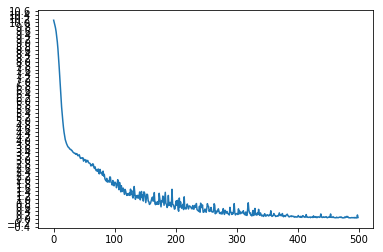

plit was shown
Wall time: 10min 42s


In [100]:
%%time
trainIters(encoder1, decoder1, imdb_lang, imdb_lines, 500, print_every=25, plot_every=1)

In [88]:
def count_parameters(model):
    model_parameters = filter(lambda p: p.requires_grad, model.parameters())
    return sum([np.prod(p.size()) for p in model_parameters])

print("Total number of trainable parameters:", count_parameters(encoder1) + count_parameters(decoder1))

Total number of trainable parameters: 6367968


In [263]:
# evaluateRandomly(encoder1, decoder1)

Visualizing Attention
---------------------

A useful property of the attention mechanism is its highly interpretable
outputs. Because it is used to weight specific encoder outputs of the
input sequence, we can imagine looking where the network is focused most
at each time step.

You could simply run ``plt.matshow(attentions)`` to see attention output
displayed as a matrix, with the columns being input steps and rows being
output steps:




In [23]:
output_words, attentions = evaluate(
    encoder1, attn_decoder1, "je suis trop froid .")
plt.matshow(attentions.numpy())

For a better viewing experience we will do the extra work of adding axes
and labels:




In [24]:
def showAttention(input_sentence, output_words, attentions):
    # Set up figure with colorbar
    fig = plt.figure()
    ax = fig.add_subplot(111)
    cax = ax.matshow(attentions.numpy(), cmap='bone')
    fig.colorbar(cax)

    # Set up axes
    ax.set_xticklabels([''] + input_sentence.split(' ') +
                       ['<EOS>'], rotation=90)
    ax.set_yticklabels([''] + output_words)

    # Show label at every tick
    ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
    ax.yaxis.set_major_locator(ticker.MultipleLocator(1))

    plt.show()


def evaluateAndShowAttention(input_sentence):
    output_words, attentions = evaluate(
        encoder1, attn_decoder1, input_sentence)
    print('input =', input_sentence)
    print('output =', ' '.join(output_words))
    showAttention(input_sentence, output_words, attentions)


evaluateAndShowAttention("elle a cinq ans de moins que moi .")

evaluateAndShowAttention("elle est trop petit .")

evaluateAndShowAttention("je ne crains pas de mourir .")

evaluateAndShowAttention("c est un jeune directeur plein de talent .")

input = elle a cinq ans de moins que moi .
output = she is as as me me me me me me
input = elle est trop petit .
output = she is an good . <EOS>
input = je ne crains pas de mourir .
output = i m not afraid of i . <EOS>
input = c est un jeune directeur plein de talent .
output = he is a good person . <EOS>
